# Probabilistic Error Cancellation  (PEC) with Cirq and Mitiq

A set-by-sep tutorial on how to use the Mitiq toolchain for implementing probabilistc error cancellation in Cirq.

## Outline

**Probabilistic error cancellation** (PEC) is an error mitigation method (K. Temme et al., Phys. Rev. Lett., 2017 and Y. Li and S. Benjamin, Phys. Rev. X, 2017). Its practical implementation can be decomposed in the following 4 tasks:

 - **Task 1: Expanding an ideal gate as linear combination of implementable noisy gates.**
 - **Task 2: Sampling an implementable gate from the representation of an ideal gate.**
 - **Task 3: Sampling an implementable circuit from the representation of an ideal circuit.**
 - **Task 4: Infer an ideal expectation value from the noisy execution of the sampled circuits.**

## Task 1: Expanding an ideal gate as linear combination of implementable noisy gates

The fist task we need to solve to implement PEC is to decompose any ideal unitary gate $G$ of some ideal circuit into a basis of implementable (noisy) gates:

$$G = \alpha_1 \tilde G_1  + \alpha_2 \tilde G_2 + \dots,$$

where $\{\alpha_j\}$ are real coefficients and $\{\tilde G_j\}$ are the implementable noisy gates, i.e., those which can be actually applied by a noisy backend. 

**NOTE: This representation depends on the particular noise model.**

For example, if the implementable gates are equal to any ideal unitary followed by a depolarizing channel:

$$ \tilde G =\mathcal E \circ G  \quad 
\text{where,}\quad \mathcal E(\rho) =  (1 - \epsilon ) \rho   + \epsilon I/2 ,$$

then, it is easy to show (Temme, Bravyi, Gambetta, 2017 or Tagagi 2020) that the following decomposition holds **for any single-qubit gate $G$**:

$$ G= \alpha_1 \tilde G_1  + \alpha_2 \tilde G_2 + \alpha_3 \tilde G_3 + \alpha_4 \tilde G_4 $$

where,
$$\alpha_1 =\left(1 + \frac{3}{4} \frac{\epsilon}{1- \epsilon} \right ), \qquad \tilde G_1 = \mathcal E \circ  G$$

$$\alpha_2 =- \frac{1}{4}\frac{\epsilon}{1- \epsilon} , \qquad \tilde G_2 = \mathcal E \circ  X \circ G$$

$$\alpha_3 =-\frac{1}{4}\frac{\epsilon}{1- \epsilon} , \qquad \tilde G_3 = \mathcal E \circ  Y \circ G$$

$$\alpha_4 =- \frac{1}{4}\frac{\epsilon}{1- \epsilon} , \qquad \tilde G_4 = \mathcal E \circ  Z \circ G$$


**Note:** the gate decomposition could be provided by the *user* or could be implemented by *mitiq* for a set of simple noise models.

### Using the `mitiq.representations` module

In [1]:
import numpy as np
from cirq import LineQubit, Circuit, X
from mitiq.pec.representations import represent_operation_with_local_depolarizing_noise

BASE_NOISE = 0.1
q = LineQubit(1)

x_rep = represent_operation_with_local_depolarizing_noise(Circuit(X(q)), noise_level=BASE_NOISE)
print(x_rep)

1: ───X─── = 1.115*1: ───X───-0.038*1: ───X───X───-0.038*1: ───X───Y───-0.038*1: ───X───Z───


## Task 2: Sampling from an implementable representation of an ideal gate

In the previous section, error cancellation was performed exactly by summing over all the terms of a gate representation. In this section instead, we are going to approximate the exact sum of all the terms by probabilistically sampling some of them. 

This approach corresponds a standard Monte Carlo approximation (with importance-sampling) of a sum of real terms. According to this procedure, each sample is associated with a sign factor (`sign`) and a normalization factor (`gamma`).

An introduction to the Monte Carlo sampling approximation of quantum circuits can be found in (Pashayan, Wallman, Bartlett, PRL 2015), in (Temme, Bravyi, Gambetta, PRL, 2017) and in (Tagagi, arXiv, 2020).

### Using the `mitiq.sampling` module

Let us take a random sample from the previous quasi-distribution.

In [2]:
from mitiq.pec.sampling import sample_sequence
from IPython.display import display

for _ in range(10):
    sampled_operation = sample_sequence(Circuit(X(q)), [x_rep])
    display(sampled_operation)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

(1: ───X───, 1, 1.230769230769231)

By running a sampled sequence in the presence of depolarizing noise (weigthed with by its sign and scaled by the representation norm) we should get an unbiased estimator of the ideal gate. We can test this, by comparing the Choi matrices of ideal and PEC operations operations.

In [3]:
# Test that the sample_sequence function can be used for doing PEC

from cirq import depolarize
from mitiq.pec.channels import _circuit_to_choi 

choi_of_ideal_x = _circuit_to_choi(Circuit(X(q)))

choi_of_noisy_x = _circuit_to_choi(Circuit(X(q) + Circuit(depolarize(BASE_NOISE)(q))))

# Take 1000 samples
samples = [sample_sequence(Circuit(X(q)), [x_rep]) for _ in range(1000)]

# Get estimators for the ideal operation
choi_of_x_pec_unbiased_estimates =[
   s[2] * s[1] * _circuit_to_choi(s[0] + Circuit(depolarize(BASE_NOISE)(q))) for s in samples
]

choi_of_pec = np.average(choi_of_x_pec_unbiased_estimates, axis=0)

print(
    "The error between the ideal and the noisy Choi matrces is:",
    np.linalg.norm(choi_of_ideal_x - choi_of_noisy_x),
)
print(
    "The error between the ideal and the PEC Choi matrces is:",
    np.linalg.norm(choi_of_pec - choi_of_ideal_x),
)

The error between the ideal and the noisy Choi matrces is: 0.115470015
The error between the ideal and the PEC Choi matrces is: 0.013831786


## Task 3: Sampling from an implementable rep. of an ideal circuit


We have seen how PEC works for a **singe gate**. What about a circuit with many gates? **We just need to sequentially sample each individual gate.** More precicely we need to:
* apply the previous sampling approach (**Task 2**) to each gate:
* multiply the `sign` of each sampled gate to get the global `sign` of the sampled circuit.
* multiply the `gamma` of each sampled gate to get the global `gamma` of the sampled circuit.

**NOTE:** The fact that one can reduce the **global sampling** into a Markov chain of **local sampling** is a consequence 
of the Monte Carlo approach. See e.g. (Pashayan, Wallman, Bartlett, PRL 2015), (Temme, Bravyi, Gambetta, PRL, 2017) and (Tagagi, arXiv, 2020).

The result of this procedure will produce an **unbiased estimator** of the ideal circuit. So, averaging over many samples we can approximate the ideal circuit.

Let us first define a simple 2-qubit circuit:

In [4]:
from cirq import X, H, CNOT

seed = np.random.RandomState(0)
q0, q1 = LineQubit.range(2)
ideal_circuit = Circuit(X(q0), H(q1), CNOT(q0, q1))
ideal_circuit

0: ───X───@───
          │
1: ───H───X───

The corresponding noisy circuit is:

In [5]:
noisy_circuit = Circuit(
    X(q0),
    depolarize(BASE_NOISE)(q0),
    H(q1),
    depolarize(BASE_NOISE)(q1),
    CNOT(q0, q1),
    depolarize(BASE_NOISE).on_each((q0, q1)),
)
noisy_circuit

0: ───X───D(0.1)───@───D(0.1)───
                   │
1: ───H───D(0.1)───X───D(0.1)───

Now we need to build the quais-probability representations for all the operations of the circuit.
For depolarizing noise, we can import a useful tool from `mitiq.pec.representations`.

In [6]:
from mitiq.pec.representations import represent_operations_in_circuit_with_local_depolarizing_noise

representations = represent_operations_in_circuit_with_local_depolarizing_noise(ideal_circuit, BASE_NOISE)
representations[1]

In [7]:
from mitiq.pec.representations import represent_operations_in_circuit_with_local_depolarizing_noise

representations = represent_operations_in_circuit_with_local_depolarizing_noise(ideal_circuit, BASE_NOISE)
# print(representations[0])
print(representations[1])
print(representations[2])

0: ───@───
      │
1: ───X─── = 1.244*0: ───@───
      │
1: ───X───+0.001*0: ───@───X───
      │
1: ───X───X───+0.001*0: ───@───X───
      │
1: ───X───Y───+0.001*0: ───@───X───
      │
1: ───X───Z───-0.043*0: ───@───X───
      │
1: ───X───────+0.001*0: ───@───Y───
      │
1: ───X───X───+0.001*0: ───@───Y───
      │
1: ───X───Y───+0.001*0: ───@───Y───
      │
1: ───X───Z───-0.043*0: ───@───Y───
      │
1: ───X───────+0.001*0: ───@───Z───
      │
1: ───X───X───+0.001*0: ───@───Z───
      │
1: ───X───Y───+0.001*0: ───@───Z───
      │
1: ───X───Z───-0.043*0: ───@───Z───
      │
1: ───X───────-0.043*0: ───@───────
      │
1: ───X───X───-0.043*0: ───@───────
      │
1: ───X───Y───-0.043*0: ───@───────
      │
1: ───X───Z───
0: ───X─── = 1.115*0: ───X───-0.038*0: ───X───X───-0.038*0: ───X───Y───-0.038*0: ───X───Z───


### Using the `mitiq.sampling` module

Let us take a random sample from the quasi-probability distribution of the full circuit.

In [8]:
from mitiq.pec.sampling import sample_circuit

sample_circuit(ideal_circuit, representations)

(0: ───X───X───@───
              │
1: ───H───────X───, -1, 2.294597528097758)

The function `sample_circuit` returns a tuple `Tuple[QPROGRAM, int, float]`, corrsponding to:
- An implementable circuit sampled from the quasi-distribution of the ideal circuit;
- The sign of the corresponding real coefficient in the quasi-distribution;
- The 1-norm of the quasi-distribution of the full circuit (the sum of the absolute values of the coefficients).

By running a sampled circuit in the presence of depolarizing noise (weigthed with by its sign and scaled by the representation norm) we should get an unbiased estimator of the ideal circuit. We can test this, by comparing the Choi matrices of the ideal and the PEC circuits.

In [9]:
# Test that the sample_circuit function can be used for doing PEC

choi_of_ideal_circuit = _circuit_to_choi(ideal_circuit)

choi_of_noisy_circuit = _circuit_to_choi(noisy_circuit)

# Take 1000 samples
circ_samples = [sample_circuit(ideal_circuit, representations) for _ in range(1000)]


# Get estimators for the ideal circuit
choi_of_pec_unbiased_estimates =[
   s[2] * s[1] * _circuit_to_choi(s[0].with_noise(depolarize(BASE_NOISE))) for s in circ_samples
]

choi_of_pec = np.average(choi_of_pec_unbiased_estimates, axis=0)

print(
    "The error between the ideal and the noisy Choi matrces is:",
    np.linalg.norm(choi_of_ideal_circuit - choi_of_noisy_circuit),
)
print(
    "The error between the ideal and the PEC Choi matrces is:",
    np.linalg.norm(choi_of_pec - choi_of_ideal_circuit),
)

The error between the ideal and the noisy Choi matrces is: 0.35779294
The error between the ideal and the PEC Choi matrces is: 0.03169106


## Task 4:  Infer  PEC expectation values with a few lines of code

Let us define a function which executes a circuit with depolarizing noise and returns an expectation value (in the case the probability of finding all qubits in the ground state).

In [10]:
from cirq import DensityMatrixSimulator

SIMULATOR = DensityMatrixSimulator()

def noisy_executor(circ: Circuit) -> float:
    """Simulates a circuit with depolarizing noise and returns the expectation value
    of the projector on the ground state |00...><00...|.
    """
    circuit = circ.with_noise(depolarize(BASE_NOISE))
    rho = SIMULATOR.simulate(circuit).final_density_matrix
    projector = np.zeros(rho.shape)
    projector[0, 0] = 1.0
    expectation = np.real(np.trace(rho @ projector))
    return expectation

def ideal_executor(circ: Circuit) -> float:
    """Simulates a circuit without  noise and returns the expectation value
    of the projector on the ground state |00...><00...|.
    """
    rho = SIMULATOR.simulate(circ).final_density_matrix
    projector = np.zeros(rho.shape)
    projector[0, 0] = 1.0
    expectation = np.real(np.trace(rho @ projector))
    return expectation

In [11]:
print("Ideal expectation value:", ideal_executor(ideal_circuit))
print("Noisy expectation value:", noisy_executor(ideal_circuit))

Ideal expectation value: 0.0
Noisy expectation value: 0.062222231179475784


### Using the `mitiq.pec` module

In order to estimate the ideal the expectation value with PEC one should:
- sample many circuits from the quasi-distribution representation of the ideal circuit
- execute all the samples with a noisy backend and get a list of noisy expectation values
- average with suitable weights (sign and norm) to estimate the ideal expectation value


If not already done, we must define an `OperationRepresentation` for each operation of the ideal circuit.

In [12]:
from mitiq.pec.representations import represent_operations_in_circuit_with_local_depolarizing_noise

representations = represent_operations_in_circuit_with_local_depolarizing_noise(ideal_circuit, BASE_NOISE)

Given the `noisy_executor` and the list of representations (`representations`) we can apply PEC with a single line of code.

In [13]:
from mitiq.pec import execute_with_pec

pec_expectation_value = execute_with_pec(
    ideal_circuit,
    noisy_executor,
    representations,
    random_state=0,  # for reproducibility
)

In [14]:
ideal_expectation_value = ideal_executor(ideal_circuit)
noisy_expectation_value = noisy_executor(ideal_circuit)
print("Absolute error wituout PEC:", abs(ideal_expectation_value - noisy_expectation_value))
print("Absolute error with PEC:", abs(ideal_expectation_value - pec_expectation_value))

Absolute error wituout PEC: 0.062222231179475784
Absolute error with PEC: 0.007030440786827054


All the raw data related to the PEC process can be easily accessed by setting `full_output=True`:

In [15]:
pec_value, pec_data = execute_with_pec(
    ideal_circuit,
    noisy_executor,
    representations,
    num_samples = 1000,
    full_output=True,
    random_state=0,  # for reproducibility
)

In [16]:
pec_data.keys()

dict_keys(['num_samples', 'precision', 'pec_value', 'pec_error', 'unbiased_estimators', 'measured_expectation_values', 'sampled_circuits'])

For example, we can extract the PEC statistical error (due to a finite number of Monte Carlo samples):

In [17]:
pec_data["pec_value"]

-0.012408694449352954

In [18]:
pec_data["pec_error"]

0.011462046913405771

In [19]:
pec_data["num_samples"]

1000

We can also analyze the raw Monte Carlo samples (`pec_data["unbiased_estimators"]`):

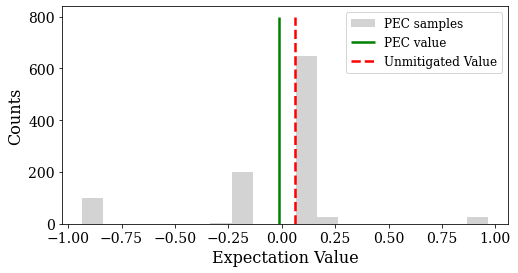

In [28]:
from matplotlib import pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 14})
fig = plt.figure(figsize=(8, 4));

data = np.round(pec_data["unbiased_estimators"]- pec_value, 5)
y_limit = 0.8 * len(data)
binwidth = 0.1

plt.hist(data, label="PEC samples", color="lightgray", bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.vlines(pec_value, 0, y_limit, "green", label="PEC value", linewidth=2.5)
#plt.vlines(ideal_expectation_value, 0, y_limit, "black", linestyle="dotted", label="Ideal Expectation Value", linewidth=3.0)
plt.vlines(noisy_expectation_value, 0, y_limit, "red", linestyle="dashed", label="Unmitigated Value", linewidth=2.5)
plt.xlabel('Expectation Value', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [29]:
# Uncomment to save the figure
fig.savefig('pec_hist.pdf')

### This notebook was executed with:

In [22]:
import mitiq

mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.9.0dev

Core Dependencies
-----------------
Cirq Version:	0.10.0
NumPy Version:	1.20.1
SciPy Version:	1.4.1

Optional Dependencies
---------------------
PyQuil Version:	2.28.0
Qiskit Version: 0.24.0
    Qiskit Elements:
        Terra : 0.16.4
        Aer : 0.7.6
        IBMQ-Provider : 0.12.3

Python Version:	3.7.7
Platform Info:	Linux (x86_64)
